# Tutorial 3: One-Mark Chromatin

Tutorials 1 and 2 introduce homopolymer simulations with `chromo`. This tutorial will demonstrate the simulation of a nucleosome-resolution chromatin fiber with one epigenetic mark, specifically H3K9me3. Descriptions in this notebook will highlight additions to the code from the previous tutorials.

#### Import Modules

Since we are modeling chromatin instead of an arbitrary SSWLC, we will import the `Chromatin` class from the `polymers` module. The chromatin fiber in this demonstration will be modified by H3K9me3, which is preferentially bound by HP1 reader proteins. Once bound HP1 reader proteins can interact with one-another. Interactions between reader proteins are captured with a uniform density field, which is implemented in the `UniformDensityField` class of the `fields` module. While beads in this demonstration represent individual nucleosomes, steric interactions between the beads are not explicitly evaluated. Instead, steric interactions are modeled using a local volume fraction constraint enforced by the field. To avoid frustration during the simulation, we need to slowly "titrate" reader proteins into the system over the course of the Monte Carlo simulation. This is a form of simulated annealing. The schedule for adding reader proteins into the system is specified in the `chromo.util.mu_schedules` module.

In [1]:
# Built-in modules
import os
import sys
from inspect import getmembers, isfunction    # We need these to select a simulated annealing schedule

# Third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from chromo.binders import get_by_name, make_binder_collection
from chromo.polymers import Chromatin   # Notice, we replaced the SSWLC with Chromatin
from chromo.fields import UniformDensityField   # Notice, we replaced the NullField with UniformDensityField
import chromo.mc as mc
import chromo.mc.mc_controller as ctrl
from chromo.util.reproducibility import get_unique_subfolder_name
import chromo.util.mu_schedules as ms    # Notice, we added the mu_schedules module

#### Specify Binders

Since we are interested in modeling chromatin modified by H3K9me3, we will want to specify HP1 binders to preferentially bind marked sites. We can use the name "HP1" to instantiate the HP1 readers.

In [2]:
# Instantiate the HP1 reader protein
hp1 = get_by_name("HP1")

You can modify the physical properties of HP1 by adjusting the attributes of the HP1 object. See documentation for the `ReaderProtein` class of the `binders` module for descriptions of the physical properties that can be modified. For the purposes of this demonstration, I will set the chemical potential of HP1 to -1.2 kT, which typically results in selective binding of HP1 to marked sites in a one-mark simulation.

In [3]:
hp1.chemical_potential = -1.2

In [4]:
# Create a binder collection with the HP1 reader protein
binder_collection = make_binder_collection(hp1)

#### Specify the Confinement

Again, we will specify a spherical confinement to contain the chromatin fiber. The radius of the confinement will be arbitrarily set to 200 nm for the purposes of this demonstration.

In [5]:
confine_type = "Spherical"
confine_radius = 200.0

#### Instantiate Epigenetic Mark Pattern

The epigenetic mark pattern must be represented by a 2D numpy array where rows correspond to nucleosome positions and columns correspond to different marks. If a mark pattern is stored in a file, it can be loaded using the `load_seqs` static method of the `Chromatin` class. Otherwise, it can be specified manually. In this case, we will specify the mark pattern manually so that the first 500 beads are unmarked, and the last 500 beads are each modified with two H3K9me3 marks (one on each histone tail). The modification states must be specified as integers.

In [6]:
num_beads = 1000
h3k9me3_pattern = np.zeros((num_beads, 1), dtype=int)
h3k9me3_pattern[500:, 0] = 2
print("Shape of mark pattern:", h3k9me3_pattern.shape)

Shape of mark pattern: (1000, 1)


#### Specify Initial Reader Protein Binding States

Each histone tail on a nucleosome can be modified with an HP1 reader protein. We need to specify the initial HP1 binding state along the chromatin fiber. Specify the initial reader protein binding states using a 2D numpy array where rows correspond to nucleosome positions and columns correspond to different reader proteins. It is common practice to assume no reader proteins are bound and then allow the simulation to reach an equilibrated binding state. In this case, we will specify that no HP1 reader proteins are initially bound to the chromatin fiber. The modification states must be specified as integers.

In [7]:
states = np.zeros((num_beads, 1), dtype=int)

#### Instantiate the Polymer

In this case, the polymer will represent a chromatin fiber. We will instantiate the `Chromatin` class instead of the `SSWLC` class. The persistence length of the polymer represented by the `Chromatin` class is automatically set to 53-nm, consistent with the persistence length of bare DNA. We will specify a bead spacing of 16.5-nm, which is representative of the typical linker length between adjacent nucleosomes. Again, we will use the `confined_gaussian_walk` class method to instantiate the polymer inside a spherical confinement. Notice, when specifying a chromatin fiber, we also specify details about the epigenetic marks and binders (specifically the modification and binding patterns as well as the mark and reader names).

In [8]:
# Specify the name, number of beads, and bead spacing of the chromatin fiber
name = "Chr"
bead_spacing = np.ones(num_beads - 1) * 16.5

# Instantiate the chromatin fiber
poly = Chromatin.confined_gaussian_walk(
    name,
    num_beads,
    bead_spacing,
    confine_type=confine_type,
    confine_length=confine_radius,
    states=states,    # Specify the initial reader protein binding states
    binder_names=np.array([hp1.name]),    # Specify the name of the reader protein
    chemical_mods=h3k9me3_pattern,    # Specify the pattern of the epigenetic mark
    chemical_mod_names=np.array(["H3K9me3"])    # Specify the name of the epigenetic mark
)

#### Specify the Uniform Density Field

Unlike a homopolymer, a chromatin fiber involves interacting reader proteins. We do not evaluate reader protein interactions explicitly, as doing so would be too computationally intensive for long fibers. Instead, we model reader protein interactions using a uniform density field, implemented in the `UniformDensityField` class of the `fields` module.

The uniform density field assumes that reader proteins occupying nearby regions of space tend to interact. Below we specify the uniform density field with voxel dimensions consistent with [MacPherson et al. _PNAS_ 2018](https://doi.org/10.1073/pnas.1812268115). We include buffer voxels to ensure that the field extends beyond the confinement. The `chi` parameter is a non-specific interaction parameter that is based on interactions between the chromatin fiber and solvent.

The `assume_fully_accessible` parameter is set to 1 to assume that each voxel is fully accessible by the chromatin fiber. This approximation is not exact for voxels along the confinement boundary, but it is reasonable enough for the purposes of this demonstration and improves computational efficiency. The `fast_field` parameter is set equal to 0, which turns off the "fast-field approximation" that would further speed up field calculations (see the documentation for the `UniformDensityField` class for more details).

In [9]:
 # Specify the dimensions of the field
n_accessible = int(np.round((63 * confine_radius) / 900))
n_buffer = 2
n_bins_x = n_accessible + n_buffer
x_width = 2 * confine_radius * (1 + n_buffer/n_accessible)
n_bins_y = n_bins_x
y_width = x_width
n_bins_z = n_bins_x
z_width = x_width

# Initialize the uniform density field
udf = UniformDensityField(
    [poly],
    binder_collection,
    x_width,
    n_bins_x,
    y_width,
    n_bins_y,
    z_width,
    n_bins_z,
    confine_type=confine_type,
    confine_length=confine_radius,
    chi=1,
    assume_fully_accessible=1,
    fast_field=0
)

#### Specify the Simulation Parameters

The simulation parameters are specified in the same way as in the previous tutorials. There are two differences in the case of a chromatin fiber:

1. We will include a "binding move" which will randomly sample HP1 binding states along the chromatin fiber.
2. We will use simulated annealing to slowly ramp up the HP1 chemical potential to -1.2 kT. This avoids frustration in the MC simulation. The simulated annealing schedules are specified in the `chromo.util.mu_schedules` module.

In [10]:
amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds(
    polymers = [poly]
)

In [11]:
num_snapshots = 200
mc_steps_per_snapshot = 1000

In [12]:
# Create a list of simulated annealing schedules, which are defined in another file
schedules = [func[0] for func in getmembers(ms, isfunction)]

# Select a schedule for slowly adding HP1 into the system
select_schedule = "linear_step_for_negative_cp"
mu_schedules = [
    ms.Schedule(getattr(ms, func_name)) for func_name in schedules
]
mu_schedules = [sch for sch in mu_schedules if sch.name == select_schedule]

#### Run the Simulation

In [13]:
# Specify the output directory
out_dir = "output_demo"

# Run the simulation
polymers = mc.polymer_in_field(
    [poly],
    binder_collection,
    udf,
    mc_steps_per_snapshot,
    num_snapshots,
    amp_bead_bounds,
    amp_move_bounds,
    output_dir=out_dir,
    mu_schedule=mu_schedules[0],
)

Save point 0 completed
Save point 1 completed
Save point 2 completed
Save point 3 completed
Save point 4 completed
Save point 5 completed
Save point 6 completed
Save point 7 completed
Save point 8 completed
Save point 9 completed
Save point 10 completed
Save point 11 completed
Save point 12 completed
Save point 13 completed
Save point 14 completed
Save point 15 completed
Save point 16 completed
Save point 17 completed
Save point 18 completed
Save point 19 completed
Save point 20 completed
Save point 21 completed
Save point 22 completed
Save point 23 completed
Save point 24 completed
Save point 25 completed
Save point 26 completed
Save point 27 completed
Save point 28 completed
Save point 29 completed
Save point 30 completed
Save point 31 completed
Save point 32 completed
Save point 33 completed
Save point 34 completed
Save point 35 completed
Save point 36 completed
Save point 37 completed
Save point 38 completed
Save point 39 completed
Save point 40 completed
Save point 41 completed
Sa

#### Plot the Resulting Configuration

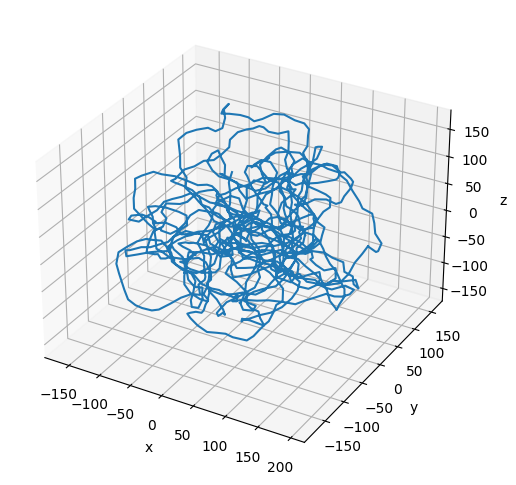

In [14]:
# Plot the final configuration of the polymer
x = polymers[0].r[:, 0]
y = polymers[0].r[:, 1]
z = polymers[0].r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(np.asarray(x), np.asarray(y), np.asarray(z))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()